In [1]:
import gev_utils as gevu

In [2]:
project_data_path = "/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024"

In [3]:
############
### Dask ###
############
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="pches",
    # account="open",
    cores=20,
    processes=1,
    memory="150GiB",
    walltime="00:20:00",
)

cluster.scale(jobs=1)  # ask for jobs

from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.8.111:37659,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import dask

In [6]:
delayed = [dask.delayed(gevu.gev_fit_single_bootstrap)(
    ensemble='LOCA2',
    gcm='CanESM5',
    member='r1i1p1f1',
    ssp='ssp245',
    metric_id='max_tasmax',
    proj_slice=[2050,2100],
    hist_slice=[1950,2014],
    periods_for_level=[10,25,50,100])
]

In [7]:
%%time
out = dask.compute(*delayed)

CPU times: user 26 s, sys: 1.85 s, total: 27.8 s
Wall time: 11min 57s


In [9]:
import xarray as xr

In [10]:
ds = xr.open_dataset('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/original_grid/max_tasmax/LOCA2_CanESM5_r1i1p1f1_ssp245_2050-2100_1950-2014_stat_lmom_bootstrap.nc')
ds_main = xr.open_dataset('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/original_grid/max_tasmax/LOCA2_CanESM5_r1i1p1f1_ssp245_2050-2100_stat_lmom_main.nc')

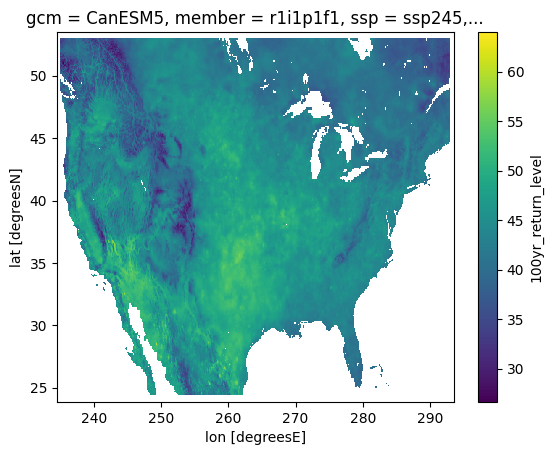

In [11]:
ds_main['100yr_return_level'].plot()

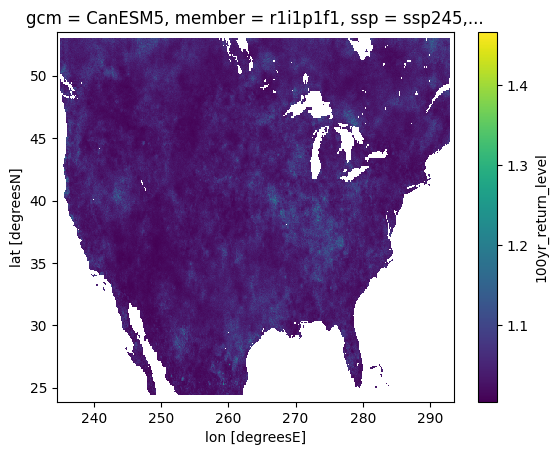

In [13]:
(ds.sel(time='proj', quantile=0.975)['100yr_return_level'] / ds_main['100yr_return_level']).plot()